Because the data for the project is very large in size, I do not have the RAM to process all the files on my laptop and it would be very slow. So I have decided to employ distributed computing systems to speed up the processing. Below I will describe the technology used for each task and compare it to the rival technologies and justify my choice.

### For storage: Google Cloud bucket.


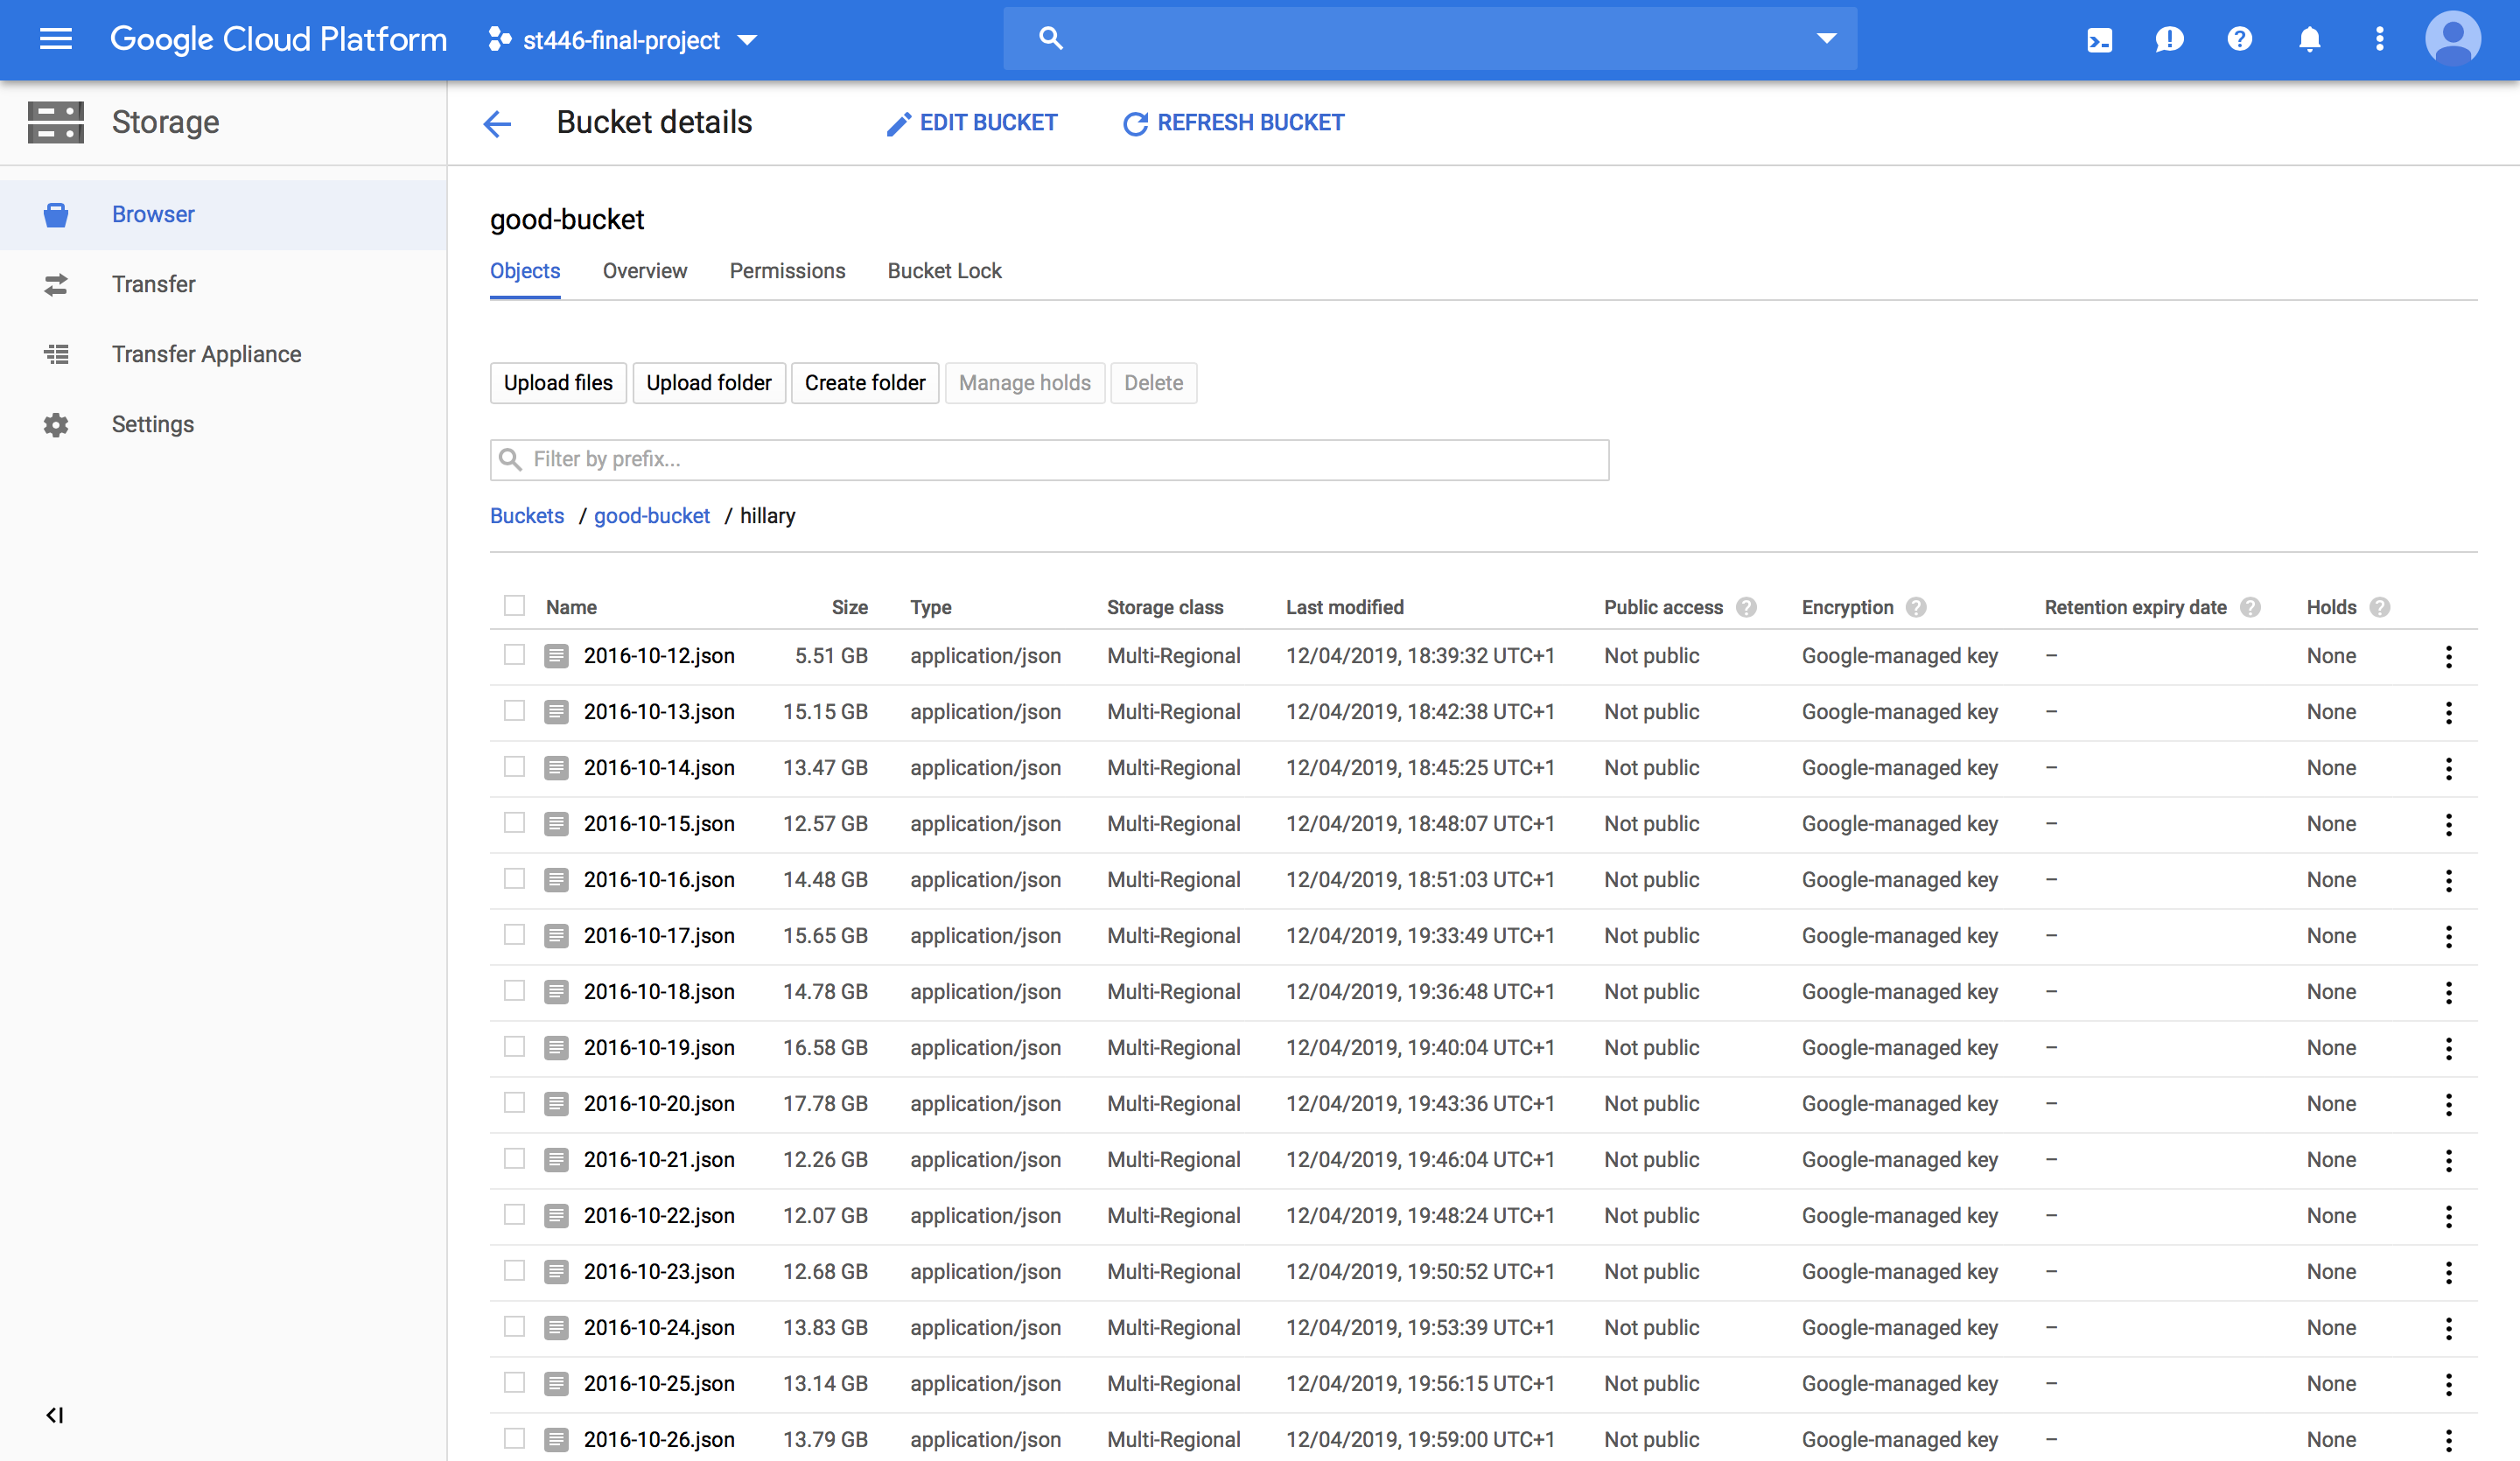

In [23]:
Image(filename='Google_cloud.png')

Google Storage (GS) stores objects (currently up to 5 TiB) that are organized into buckets (as S3 does) identified within each bucket by a unique, user-assigned key. All requests are authorized using an access control list associated with each bucket and object. Bucket names and keys are chosen so that objects are addressable using HTTP URLs.

##### The reason why I chose Google Storage was for consistency. Upload operations to Google Storage are atomic, providing strong read-after-write consistency for all upload operations.Compared to its rivals, Google Storage provides extra  list after write consisenct.

#### Google Storage Consistency

The consistency is achieved by putting Cloud Storage metadata into Spanner, Google’s globally distributed and strongly consistent relational database. Spanner is a sharded (horizontally sharded, split rows instead of columns), geo-replicated relational database (replicate the shards to different machines). 

* Logging: 
Spanner’s transactions use a replicated write-ahead redo log, and the Paxos consensus algorithm is used to get replicas to agree on the contents of each log entry. In particular, each shard of the database is assigned to exactly one Paxos group (replicated state machine). A given group may be assigned multiple shards. All transactions that involve data in a particular group write to a logical Paxos write-ahead log, which means each log entry is committed by successfully replicating it to a quorum of replicas.


* Reading: 
Reads can be done in lock-free snapshot transactions, and all data returned from all reads in the same snapshot transaction comes from a consistent snapshot of the database at a specified timestamp. Stale reads choose a timestamp in the past to increase the chance that the nearby replica is caught up enough to serve the read. Replicas retain several previous data versions to be able to serve stale reads. Strong reads see the effects of all previously committed transactions; to ensure this we choose a read timestamp guaranteed to be greater than the commit timestamp of all possible previous transactions. Strong reads may have to wait for the nearby replica to become fully caught up, or may retry at a further away replica that may be more up-to-date. 


* Locating data: 
Spanner provides a special RPC framework, called the coprocessor framework, to hide much of the complexity of locating data. Read and write requests are addressed to a key or key range, not to a particular server. The coprocessor framework determines which Paxos group (or groups) owns the data being addressed, and finds the 
nearest replica of that group that is sufficiently up-to-date for the specified concurrency mode. Data shards may move from one Paxos group to another or be split into smaller shards in new groups (usually for load balancing reasons). In this case the coprocessor framework transparently reroutes requests to the new group’s replicas even if the move happens while the request is in progress. 

### For efficient analysis,  I used pysark on Google Clusters. 

##### I chose Pyspark mainly because of its comprehensive ability of carrying out all the tasks required in the project, the easy syntax and the fast speed in processing utilisisng the computing power of Google Cluster. In additionm, for each specific task, the corresponding technology in pyspark provides some advantages over its rivals.

Apache Spark is an open-source cluster computing framework. It was originally developed by Matei Zaharia in 2014 and later donated to the Apache Spark Foundation. The framework is built on top of the Hadoop Distributed File System (HDFS). It works on distributed processing of data, handing out data to separate worker nodes for processing. The worker nodes are managed by a master node which dispatches and schedules the distributed tasks. Hence, Spark requires a cluster manager and distributed storage system. 

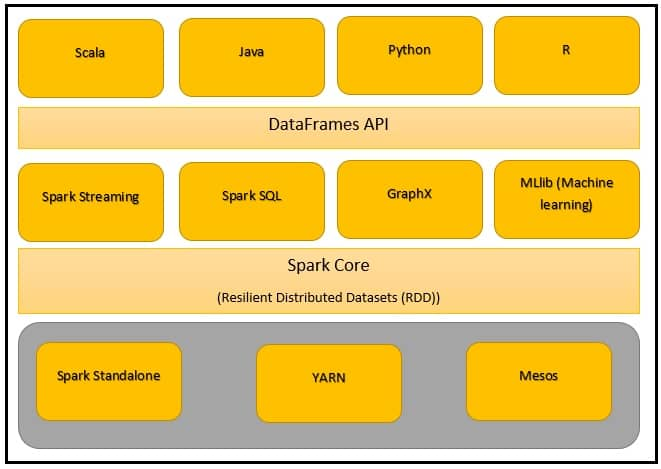

In [25]:
Image(filename='spark_architecture.jpg')

#### Architecture

* Spark Core serves as the underlying general execution engine and is the foundation of Apache Spark. It supports dispatching of distributed tasks, their scheduling and I/O functionalities. This is made possible through an application programming interface (API) for Java, R, Python and Scala. With interfaces present for many languages, it can support a wide variety of languages. It delivers speed utilizing the in- memory computing capabilities . The API follows a higher-level programming approach with use of a driver program that calls parallel operations on a Resilient Distributed Dataset (RDD) by passing a function to Spark. The core schedules the execution in parallel on the available clusters. Until Spark 2.1.x, Resilient Distributed Dataset (RDD) was the primary API. It is a fault-tolerant, read-only collection of dataset which is distributed over the cluster machines for processing. From Spark 2.2.x, the Dataset API is promoted, though RDD is still in use. 


* On top of the Spark Core, there are four components namely Spark SQL, Spark Streaming, Machine Learning library and GraphX. Spark SQL is the module of Spark that deals with structured data using dataframes. It has a SQL-like interface to query and process data. Spark Streaming allows to add real-time processing of data in addition to Spark’s batch processing. It breaks down the incoming data stream into micro batches and processes them in the same way as batch processes in Spark. Both processes work on the same code in the same framework, thus reducing overhead. GraphX is a distributed framework on top of Spark for processing graph structures. It allows users to build and process graph structured data interactively [30]. The Machine Learning library allows to implement the machine learning pipelines in a distributed manner, thereby decreasing the overall processing time significantly. There are a growing number of machine learning algorithms for Classification, Clustering, Collaborative Filtering, Regression and Dimensionality Reduction. All algorithms are implemented in a distributed fashion and allow for easy execution of feature extraction, selection, and transformation on structured dataset. It provides tools for constructing, evaluating and tuning ML pipelines, along with saving and loading algorithms, models and pipelines 

#### Resilient Distributed Dataset (RDD)

* Resilient Distributed Dataset is the primary API in Spark since its deployment. It is an immutable collection of elements of data, which is distributed among the different nodes in the cluster. These nodes could then be operated in parallel using the operations defined for RDDs . The operations are split across the cluster, executed in parallel leading to reduced time in processing . RDDs are fault-tolerant since they can be reconstructed in case of loss by keeping track of the sequences that produced them . They can be created in two ways: parallelizing an existing dataset in your program or referencing a dataset from an external storage program like HDFS, Hbase, etc.


* There are two types of operations available with RDDs, “transformations” and “actions”. Transformations create a new RDD from an existing one, and Actions return a value to the driver program after running computation on a RDD. All transformations are lazy in Spark, which is they do not compute the results immediately. Instead, they remember the computation that needs to be performed and apply that computation only when an action is applied by driver program. This design helps to run Spark efficiently . 


* An action is “reduce” which reduces the RDD into a collective value by passing through a defined function. As explained, transformations like map is a lazy operation and will only be evaluated when reduce or any other action will be called on the RDD. I have used transformation and reduce, count actions in my project. “Filter” filters the RDD based on a filter function, and “Count” returns the number of elements in the RDD passed to it. One of the interesting properties of Spark is the ability to cache datasets in memory. When a dataset is persisted, each node that has used the dataset to do some computation will store it in partitions and reuse it later for other actions. This helps in faster usage of datasets. The datasets can be persisted in a number of different ways: only in memory (default level), memory and disk, disk only. These storage levels are available for simultaneous replication on two nodes as well.


#### Spark Context
* The Spark Context is the main entry point for Spark functionality. It allows the driver program to access the clusters through the means of a cluster manager like YARN, Mesos, etc. There must only be one active Spark Context per JVM. 
We require Spark Conf to create the Spark Context. It stores configuration parameters like cluster size, cores, application name to connect driver program to the cluster, etc. Now I will describe The relationship between the driver application, the cluster resource manager and executors.  Each cluster has one driver node and one or more worker nodes. These worker nodes have executors, which can be accessed by the driver application through the Spark Context. As soon as the driver program starts executing, the Spark Context creates a job and breaks it into stages. These stages are further broken into tasks which are scheduled by the Spark Context on each executor. These executors run the user code, run computations and cache the data for the application. They return the result back to driver application

### 1. For preprpocessing and fact-checking, I used pyspark sql dataframe.

An alternative for pyspark sql is hive. They do more or less the same thing. Hive is an open source data warehouse system built on top of Hadoop Haused for querying and analyzing large datasets stored in Hadoop files. Users just need to submit merely SQL queries. Also, it enables users to plug in custom MapReduce scripts into queries. 

##### There are two main reasons why I choose to implement in pyspark sql. One is a better user experience. I prefer notebook than submitting hive jobs.  Two is the data is already stored in Google Cloud Storage. Pyspark can directly read from Google buckets while I have to put files into hadoop data storage for hive to access which wastes time.

#### Comparision of Spark SQL and Hive:

* Apache Hive: Work well for large datasets to query: Hive is designed specifically for analytics on large datasets and works well for a range of complex queries. Hive is the most approachable way to quickly (relatively) query and inspect datasets already stored in Hadoop. If extensibility is important: Hive has a range of user function APIs that can be used to build custom behavior in to the query engine.

* Spark SQL:It is used to performs SQL queries.We can read data from existing Hive installation.While we perform on spark SQL We get the result as Dataset/DataFrame. 

### 2. For topic modelling and analysis of tweet and user level features (logistic regression), I used pyspark Mlib.

MLlib is Spark’s distributed machine learning library, and the largest such library. The library targets large-scale learning settings that benefit from data- parallelism or model-parallelism to store and operate on data or models. MLlib consists of fast and scalable implementations of standard learning algorithms for common learning settings.

MLlib’s tight integration with Spark results in several benefits. The most imprtant one, since Spark is designed with iterative computation in mind, it enables the development of efficient implementations of large-scale machine learning algorithms since they are typically iterative in nature. Improvements in low-level components of Spark often translate into performance gains in MLlib, without any direct changes to the library itself.


##### Two main benefits of using Mllib is in Pipeline API and Spark Integration

* Practical machine learning pipelines often involve a sequence of data pre-processing, feature extraction, model fitting, and validation stages. Most machine learning libraries do not provide native support for the diverse set of functionality required for pipeline construction. Leveraging Spark’s rich ecosystem and inspired by previous work, MLlib includes a package aimed to address these concerns. This package, called spark.ml, simplifies the development and tuning of multi-stage learning pipelines by providing a uniform set of high-level APIs.


* MLlib benefits from the various components within the Spark ecosystem. For example, at the lowest level, Spark core provides a general execution engine with over 80 operators for transforming data. Spark SQL provides data integration functionality, SQL and structured data processing which can simplify data cleaning and preprocessing, and also supports the DataFrame abstraction which is fundamental to the spark.ml package.

### 3. For network analysis, I used Spark GraphFrame.

GraphFrames is an integrated system that can combine relational processing, pattern matching and graph algorithms and optimize computations across them. GraphFrames generalize the ideas behind GraphX and Vertexica by maintaining arbitrary views of a graph (e.g., triplets or triangles) and executing queries using joins across them. They then optimize execution across the relational and graph portions of the computation.

####  GraphFrame Data Model

A GraphFrame is logically represented as two DataFrames: an edge DataFrame and a vertex DataFrame. That is to say, edges and vertices are represented in separate DataFrames, and each of them can contain attributes that are part of the supported types. The GraphFrame model supports user-defined attributes with each vertex and edges. GraphFrame is more general than Pregel/Giraph since GraphFrame supports user-defined attributes on edges.
Similar to DataFrames, a GraphFrame object is internally represented as a logical plan, and as a result the declaration of a Graph-Frame object does not necessarily imply the materialization of its data.

In [ ]:
class GraphFrame {
// Different views on the graph
def vertices: DataFrame
def edges: DataFrame
def triplets: DataFrame
// Pattern matching
def pattern(pattern: String): DataFrame
// Relational-like operators
def filter(predicate: Column): GraphFrame
def select(cols: Column*): GraphFrame
def joinV(v: DataFrame, predicate: Column): GraphFrame
def joinE(e: DataFrame, predicate: Column): GraphFrame
// View creation
def createView(pattern: String): DataFrame
// Partition function
def partitionBy(Column*) GraphFrame
}

# GraphFrame API in Scala

#### Edges, Vertices, Triplets, and Patterns

A GraphFrame exposes four tabular views of a graph: edges, vertices, triplets, and a pattern view.
The edges view and the vertices view should be self-evident. The triplets view consists of each edge and its corresponding source and destination vertex attributes. 

In addition to the three basic tabular views, a GraphFrame also supports a pattern operator that accepts a graph pattern in a Cypher- like syntax and returns a DataFrame consisting of edges and vertices specified by the pattern. This pattern operator enables easy expression of pattern matching in graphs.

Typical graph patterns consist of two nodes connected by a directed edge relationship, which is represented in the format ()-[]->(). () represents nodes, - represnets edges. Note that the pattern operator is a simple and intuitive way to specify pattern matching. Under the hood it is implemented using the join and filter operators available on a GraphFrame. 

#### Comparsion with GraphX

Similar to GraphX, GraphFrames by default partitions a graph based on the natural partitioning scheme of the edges. 

##### In addition, GraphFrame supports partitioning a graph based on arbitrary vertex or edge attributes. This is more general than GraphX or Giraph because they only support partitioning on vertex identifiers. This enables users to partition a graph based on their domain-specific knowledge that can lead to strong data locality and minimize data communications.



### Lastly, To reproduce the analysis for the project:

One need to do preprocessing and intialise a cluster. See http://localhost:8888/edit/helper/preprocessing.md and http://localhost:8888/edit/helper/cluster.md for more details.